In [1]:
import pandas as pd
import sys
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, train_test_split
import numpy as np
from IPython import embed
from sklearn import metrics, svm
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFpr, SelectKBest, SelectFromModel,chi2, f_classif
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTE
%matplotlib inline
sns.set(color_codes=True)

In [2]:
file = "../categories/no_GT/border/trump/trump_cleaned.csv"
sar = "../../Sarcasm/sarcasm_cleaned.csv"
raw = pd.read_csv(file).drop_duplicates()

sarcasm = pd.read_csv(sar)
sarcasm = sarcasm.drop_duplicates()
sarcasm.columns = ['contents',
                 'Bernie',
                 'Trump',
                 'Clinton',
                 'Cruz',
                 'Num of Candidate',
                 'Sarcasm_s1',
                 'Sarcasm_s2',
                 'Sarcasm_s3',
                 'Sarcasm_s4',
                 'Sarcasm_s5',
                 'Sarcasm_s6',
                 'Sarcasm_s7',
                 'Number of Sarc',
                 'Short and link']

res = pd.merge(raw, sarcasm, how='left', on=['contents']).dropna()
res = res.drop_duplicates()

del res['Bernie'], res['Trump'], res['Clinton'], res['Cruz']

del raw, sarcasm

raw = res

print raw.head()

print 'Total # of samples: ', len(raw)


                                            contents  label  Num of Candidate  \
0         candic bergen detail date trump short even      0                 1   
1  roundup cruz defeat trump clinton narrowli def...      0                 4   
2                                 donald trump trash      0                 1   
3  trump audit ir everi year candid probabl never...      0                 1   
4                    trump landslid nite ll c cahang      0                 1   

   Sarcasm_s1  Sarcasm_s2  Sarcasm_s3  Sarcasm_s4  Sarcasm_s5  Sarcasm_s6  \
0           1           0           0           0           0           0   
1           0           0           1           0           0           0   
2           0           0           0           0           0           0   
3           0           0           1           0           0           0   
4           0           0           0           0           0           0   

   Sarcasm_s7  Number of Sarc  Short and link  
0 

In [3]:
raw.count()
list(raw.columns)

['contents',
 'label',
 'Num of Candidate',
 'Sarcasm_s1',
 'Sarcasm_s2',
 'Sarcasm_s3',
 'Sarcasm_s4',
 'Sarcasm_s5',
 'Sarcasm_s6',
 'Sarcasm_s7',
 'Number of Sarc',
 'Short and link']

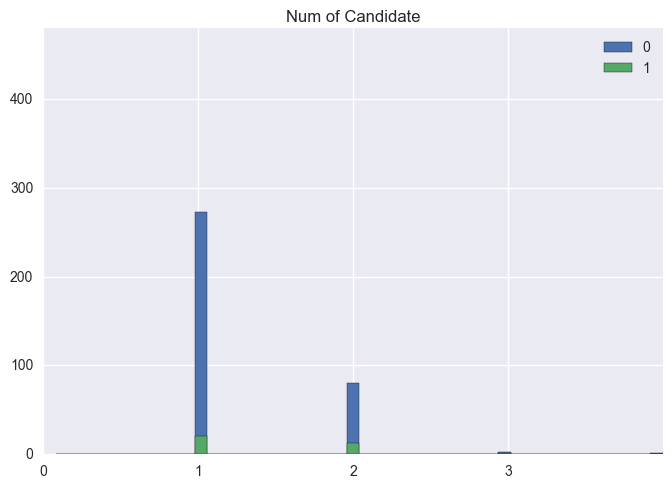

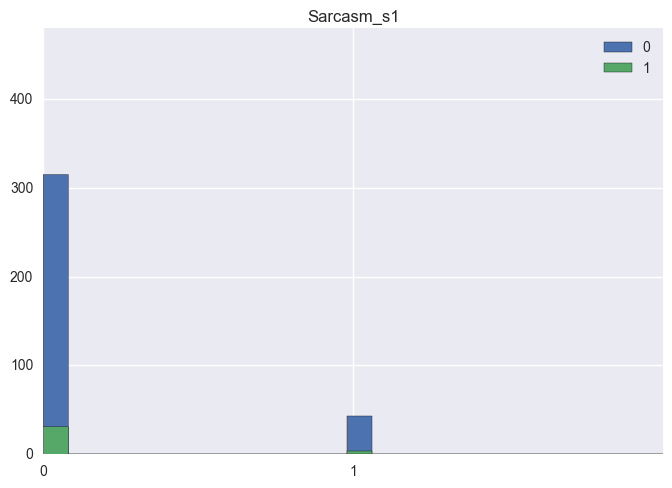

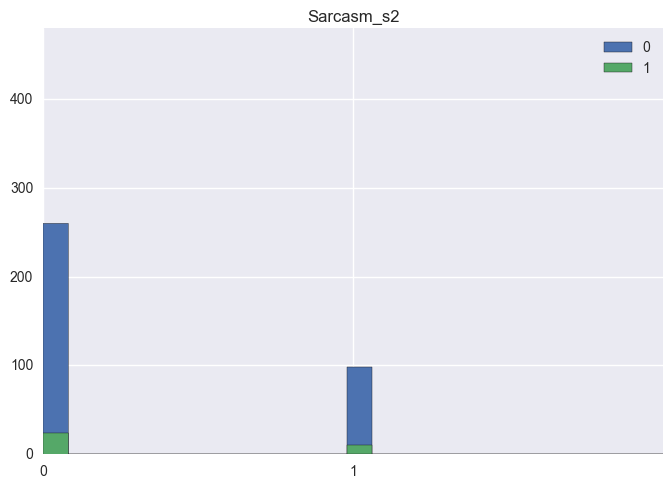

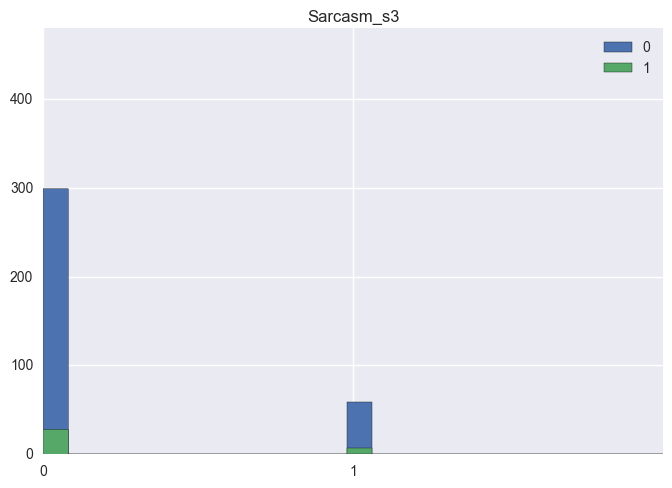

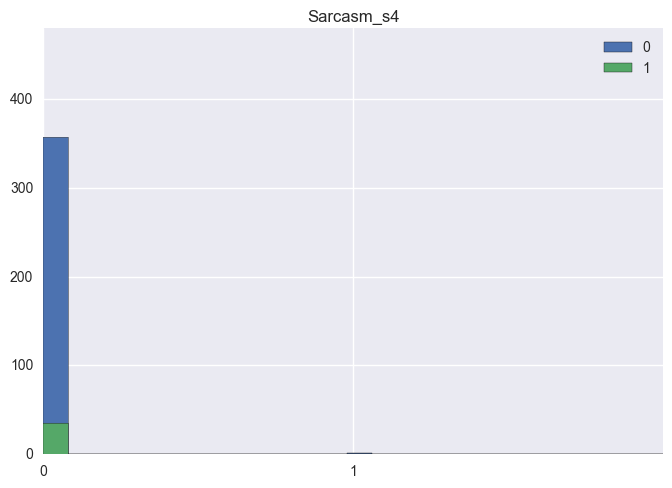

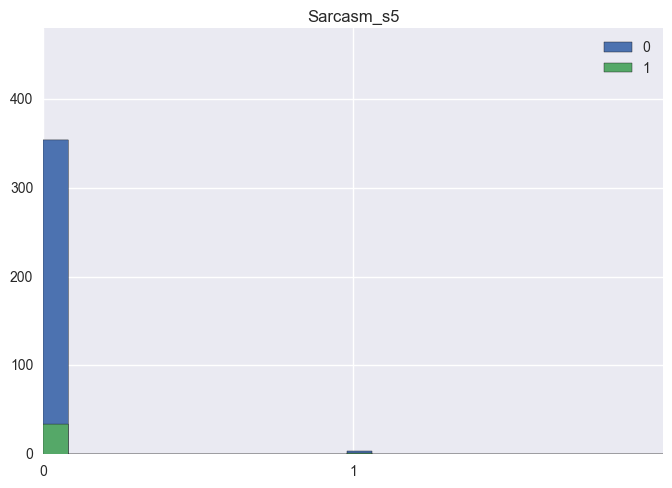

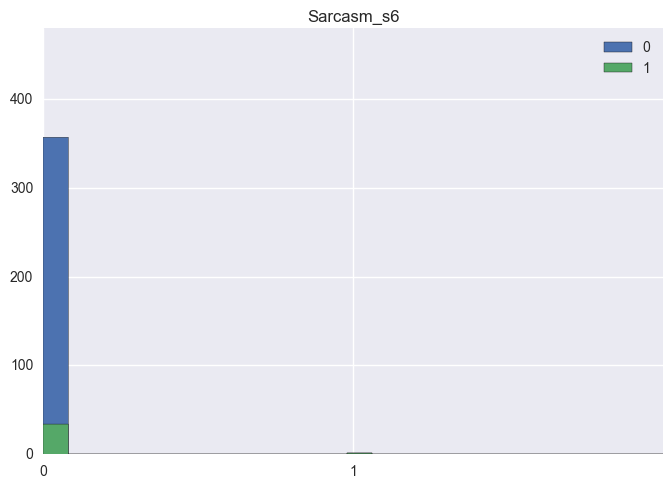

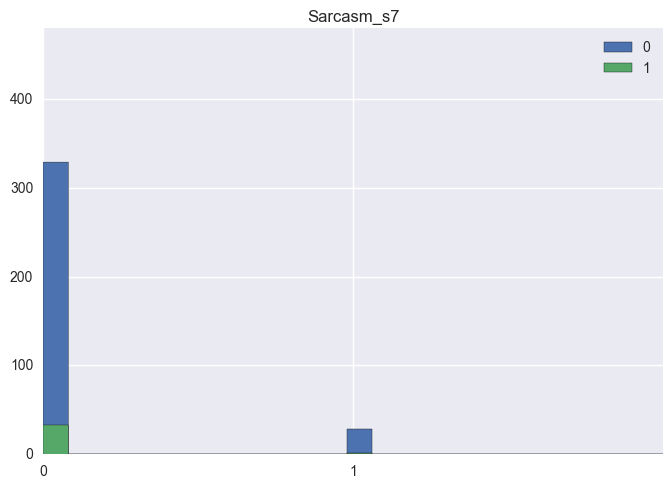

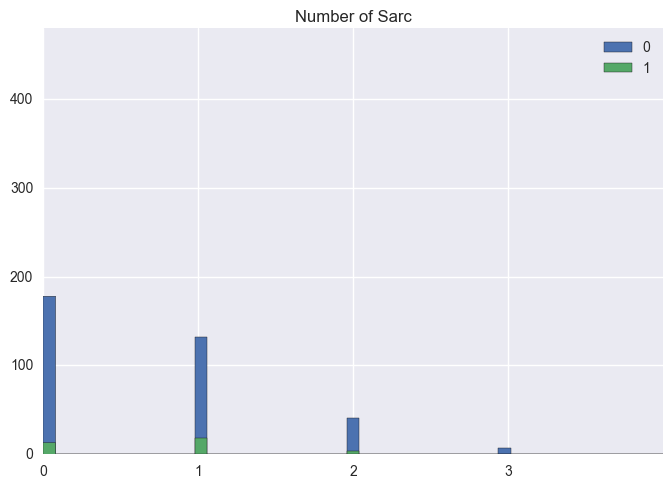

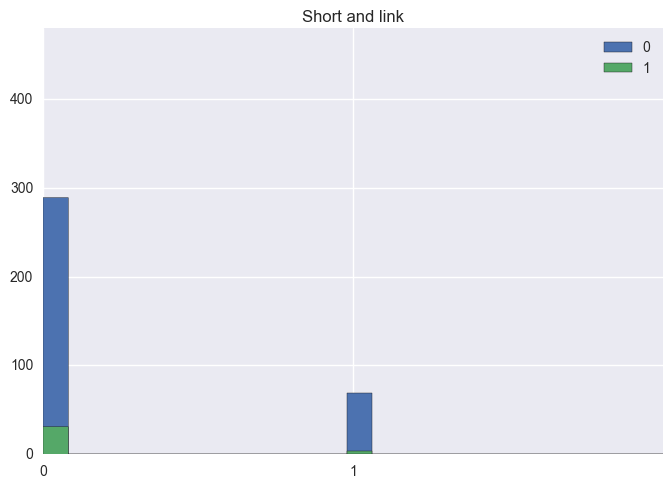

In [4]:
for i in range(2,len(raw.columns)):
    plt.figure(i)
    x1 = raw[raw['label']==1][raw.columns[i]].tolist()
    x0 = raw[raw['label']==0][raw.columns[i]].tolist()
#     sns.distplot(x0, rug=True, kde=False, bins=np.linspace(0,4), label='0')
#     sns.distplot(x1, rug=True, kde=False, bins=np.linspace(0,4), label='1')
    sns.color_palette('hls',8)
    plt.hist(x0,stacked=True,bins=np.linspace(0,4), label='0')
    plt.hist(x1,stacked=True,bins=np.linspace(0,4), label='1')
    plt.xticks( range(len(set(x0))) )
    plt.xlim(0, len(set(x0)))
    plt.ylim(0,480)
    plt.legend()
    plt.title(raw.columns[i])

In [5]:
print "Percentage of positive samples in all: %0.3f  "%(float(len(raw[raw['label']==1]))/len(raw) * 100)

Percentage of positive samples in all: 8.906  


In [6]:
X = raw[['contents',
                'Num of Candidate',
                 'Sarcasm_s1',
                 'Sarcasm_s2',
                 'Sarcasm_s3',
                 'Sarcasm_s4',
                 'Sarcasm_s5',
                 'Sarcasm_s6',
                 'Sarcasm_s7',
                 'Number of Sarc',
                 'Short and link']]

y = np.array(raw['label'], dtype='int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
feature_cols = ['Num of Candidate',
                 'Sarcasm_s1',
                 'Sarcasm_s2',
                 'Sarcasm_s3',
                 'Sarcasm_s4',
                 'Sarcasm_s5',
                 'Sarcasm_s6',
                 'Sarcasm_s7',
                 'Number of Sarc',
                 'Short and link']

In [8]:
def textPreprocess(text, train=True):
    global vectorizer, weighting
    if train:
        vectorizer = CountVectorizer(min_df=0.005, stop_words='english', ngram_range=(1,1))
        weighting = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=False, sublinear_tf=False)
        text_token = weighting.fit_transform(vectorizer.fit_transform(text))

    text_token = weighting.transform(vectorizer.transform(text))
    return text_token, vectorizer, weighting

In [9]:
train_text, vectorizer, weighting = textPreprocess(X_train['contents'], train=True)

train_text.todense().shape


(275, 296)

In [10]:
len(vectorizer.vocabulary_)

296

In [11]:
X_train.index

Int64Index([109,  17, 352,  24, 126, 363, 175, 232, 193, 238,
            ...
            214, 121, 392,  20, 188,  71, 106, 270, 348, 102],
           dtype='int64', length=275)

In [12]:
train_text_df = pd.DataFrame(train_text.todense(),columns=list(vectorizer.vocabulary_), dtype='int64', index=X_train.index)

print train_text_df.shape

X_train_df = pd.concat([train_text_df, X_train[feature_cols]], axis=1)
print X_train_df.shape

X_train_df.head()

(275, 296)
(275, 306)


,liar,voter,ron,tweet,articl,ti,far,candid,servic,ted,...,Num of Candidate,Sarcasm_s1,Sarcasm_s2,Sarcasm_s3,Sarcasm_s4,Sarcasm_s5,Sarcasm_s6,Sarcasm_s7,Number of Sarc,Short and link
109,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,1
352,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
126,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


In [13]:
# sm = SMOTE(kind='svm', random_state = 2017, k_neighbors=4, m_neighbors=12)
# X_train_df, y_train = sm.fit_sample(X_train_df, y_train)

# print "After sampling: ", X_train_df.shape
# print "Percentage of positive samples become: %0.3f  "%(float(sum(y_train==1))/len(y_train) * 100)

In [14]:
test_text, vectorizer, weighting = textPreprocess(X_test['contents'], train=False)

print test_text.todense().shape

test_text_df = pd.DataFrame(test_text.todense(),columns=list(vectorizer.vocabulary_), dtype='int64', index=X_test.index)

X_test_df = pd.concat([test_text_df, X_test[feature_cols]], axis=1)
print X_test_df.shape

X_test_df.sample(10)



(118, 296)
(118, 306)


,liar,voter,ron,tweet,articl,ti,far,candid,servic,ted,...,Num of Candidate,Sarcasm_s1,Sarcasm_s2,Sarcasm_s3,Sarcasm_s4,Sarcasm_s5,Sarcasm_s6,Sarcasm_s7,Number of Sarc,Short and link
157,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
93,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
381,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,1
209,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
63,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
195,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
369,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
118,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
79,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [15]:
parameters = {

    'clf__C': (1.0, 0.9, 0.8,0.7, 0.6, 0.5, 0.4),
#     'clf__penalty': ('l1','l2'),
    'clf__dual': (True, False),
#     'clf__loss': ('hinge', 'squared_hinge'),
    'clf__tol': (1e-3, 1e-4, 1e-5)

}

In [16]:
def tuner(X, y, NUM_TRIALS, param, K, select=True):
    '''

    :param param: dict containing parameters to tune
    :param k: KFold Cross-Validation
    :return: model and scores
    '''

    piper = Pipeline([
        ('clf', svm.LinearSVC(class_weight='balanced'))
    ])
    if select:
        global sel
        sel = SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=250,
                              random_state=0, min_samples_leaf = 0.05), threshold="0.6*mean")
        X = sel.fit_transform(X,y)
        print X.shape
#         print sel.feature_importance_
    parameters = param
    scores = np.zeros(NUM_TRIALS)
    CCR = np.zeros(NUM_TRIALS)
    models = []
    t0 = time()
    for i in range(NUM_TRIALS):

        print(i)

        inner_cv = KFold(n_splits = K, shuffle=True, random_state=i)

        model = GridSearchCV(piper, param_grid=parameters, cv=inner_cv, n_jobs=-1, scoring='precision') # accuracy no good, TPR/recall no good
        model.fit(X, y)

        scores[i] = model.best_score_
        models.append(model)
    print("done in %0.3fs" % (time() - t0))

    return (models, scores)

In [17]:
res_models, eval_score = tuner(X_train_df,y_train,7,parameters, K=5, select=True)

(275, 7)
0
1
2
3
4
5
6
done in 5.203s


In [18]:
print eval_score

res_models[eval_score.argmax()].best_params_

[ 0.06875817  0.0544733   0.05879061  0.04333333  0.05650062  0.05488889
  0.04143504]


{'clf__C': 1.0, 'clf__dual': True, 'clf__tol': 1e-05}

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train_df = sel.transform(X_train_df)
print X_train_df.shape
clf = res_models[eval_score.argmax()].best_estimator_.fit(X_train_df, y_train)
# X_test_df = sel.transform(X_test_df)
print X_test_df.shape
predicted = clf.predict(X_test_df)

# embed()

print(metrics.classification_report(y_test, predicted))
print("Precision: %0.2f" % (metrics.precision_score(y_test, predicted)*100))
print("TPR(recall): %0.2f" % (metrics.recall_score(y_test, predicted)*100))
# print("F1_score: %0.2f" % (metrics.f1_score(y_test, predicted)*100))


cmat = metrics.confusion_matrix(y_test, predicted)


print("CCR: %0.2f"%(float((cmat[0][0]+cmat[1][1]))* 100/sum(sum(cmat))))
print("FPR: %0.2f"%(float(cmat[0][1])* 100/(cmat[0][0]+cmat[0][1])))
print(cmat)
print("Percentage of predicted positives %0.2f" % (float((cmat[0][1] + cmat[1][1])) * 100 / sum(sum(cmat))))




(275, 306)
(118, 306)
             precision    recall  f1-score   support

          0       0.88      0.69      0.77       103
          1       0.14      0.33      0.19        15

avg / total       0.78      0.64      0.70       118

Precision: 13.51
TPR(recall): 33.33
CCR: 64.41
FPR: 31.07
[[71 32]
 [10  5]]
Percentage of predicted positives 31.36


In [25]:
data.columns


Index([u'contents', u'Num of Candidate', u'Sarcasm_s1', u'Sarcasm_s2',
       u'Sarcasm_s3', u'Sarcasm_s4', u'Sarcasm_s5', u'Sarcasm_s6',
       u'Sarcasm_s7', u'Number of Sarc', u'Short and link'],
      dtype='object')

In [128]:

for i in range(524,len(data.columns)-1): 
    plt.figure(i)
    x0 = np.array(data[data['label']==0][data.columns[i]])
    x1 = np.array(data[data['label']==1][data.columns[i]])
    sns.distplot(x0, kde=False, rug=True, label="unified")
    sns.distplot(x1, kde=False, rug=True, label='diversified')
    plt.legend()
    plt.title(data.columns[i])
    


plt.show()



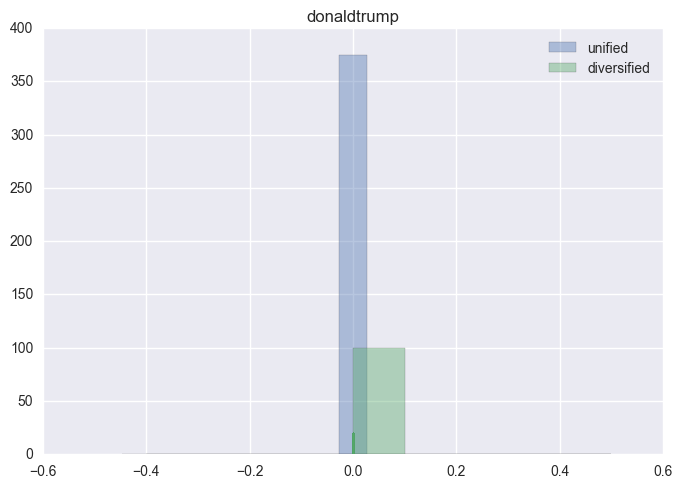

In [129]:
for i in

plt.figure()
x0 = np.array(data[data['label']==0]['donaldtrump'])
x1 = np.array(data[data['label']==1]['donaldtrump'])
sns.distplot(x0, kde=False, rug=True, label="unified")
sns.distplot(x1, kde=False, rug=True, label='diversified')
plt.legend()
plt.title('donaldtrump')




In [123]:
len(raw[raw['label']==1])


100

In [140]:
count=0
for i in range(len(data.columns)):
    if len(set(data[data.columns[i]]))==1:
        print data.columns[i],set(data[data.columns[i]])
        count +=1
print count

care set([0])
notic set([0])
hold set([0])
want set([0])
wrong set([0])
carson set([0])
listen set([0])
donaldtrump set([0])
runner set([0])
bush set([0])
busi set([0])
new set([0])
result set([0])
fail set([0])
best set([0])
countri set([0])
right set([0])
support set([0])
tell set([0])
time set([0])
hot set([0])
sai trump set([0])
love set([0])
sc set([0])
didn set([0])
polit set([0])
vote set([0])
sai set([0])
noth set([0])
carolina set([0])
better set([0])
come set([0])
trump presid set([0])
cruz rubio set([0])
candid set([0])
isn set([0])
mexican set([0])
realli set([0])
believ set([0])
guess set([0])
jeb set([0])
plan set([0])
cover set([0])
person set([0])
clinton set([0])
try set([0])
video set([0])
let set([0])
great set([0])
ted cruz set([0])
anyth set([0])
endors set([0])
tonight set([0])
fact set([0])
hope set([0])
ve set([0])
cruz set([0])
year set([0])
sander set([0])
voter set([0])
work set([0])
disappoint set([0])
break set([0])
donald trump set([0])
strong set([0])
nig

In [137]:
len(set(data['donaldtrump']))


1

In [36]:
train = pd.concat([X_train_df, pd.DataFrame(y_train, index=X_train_df.index, columns=["label"])],axis=1)

print train.shape

test = pd.concat([X_test_df, pd.DataFrame(y_test, index=X_test_df.index, columns=["label"])],axis=1)

print test.shape

data = pd.concat([train, test], axis=0)

print data.shape

(332, 238)
(143, 238)
(475, 238)


In [37]:
data.head()

,second,new,campaign,tell,notic,hold,want,hot,wrong,better,...,Sarcasm_s1,Sarcasm_s2,Sarcasm_s3,Sarcasm_s4,Sarcasm_s5,Sarcasm_s6,Sarcasm_s7,Number of Sarc,Short and link,label
312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
29,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
182,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,2,0,0
392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [38]:
y = data['label']
del data['label']
X = data

In [22]:
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [63]:
Y =np.array(y, dtype='int64')


In [66]:
len(X_tsne[Y == 1,0])

100

Computing t-SNE embedding


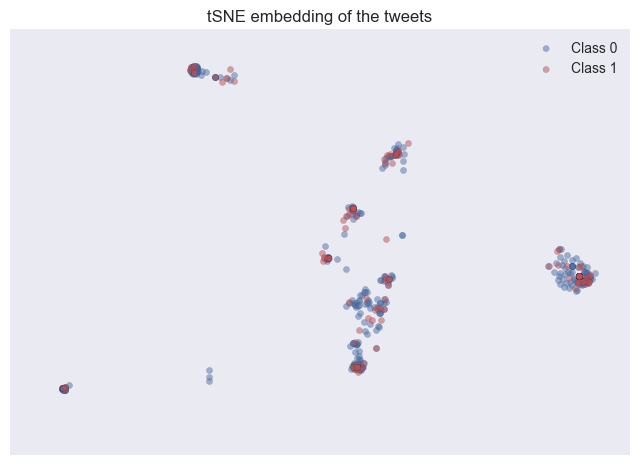

In [74]:
almost_black = '#262626'
palette = sns.color_palette()
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=1)
t0 = time()
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[Y == 0,0],X_tsne[Y == 0,1], label='Class 0',alpha=0.5,
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(X_tsne[Y == 1,0], X_tsne[Y == 1,1],label='Class 1',alpha=0.5,
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
plt.legend()
# imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
#                 X[i])
# plt.add_artist(imagebox)
plt.title('tSNE embedding of the tweets')
plt.xticks([]), plt.yticks([])
plt.show()

In [24]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
